In [3]:
#General Imports
import math
import numpy as np 
import matplotlib.pyplot as plt
import pylab as pl


#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.svm import SVC 

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel

from utils2 import *

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'


SEED = 1430

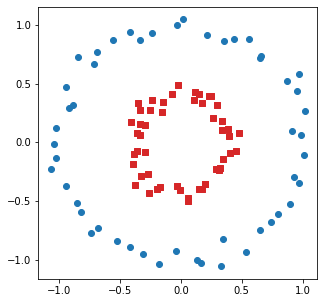

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles

n_samples = 100

# Create circles dataset
X, Y = make_circles(n_samples=n_samples, noise=0.05, factor=0.4) 

# Separate smaller and larger circles
A = X[np.where(Y==0)] #50 points for A
B = X[np.where(Y==1)] #50 points B


# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='C3')
plt.show()


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=0)

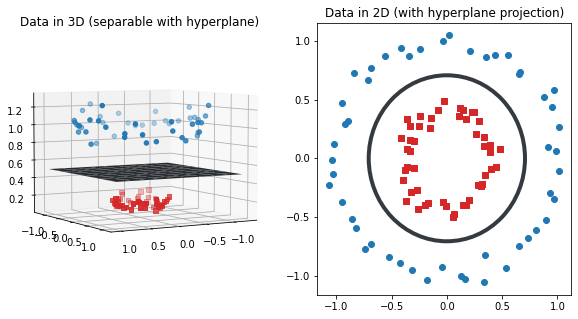

In [6]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    return np.array([x, y, x**2.0 + y**2.0])

plot_transform(A,B,X,Y)

In [7]:
nb_features_circles = 2

x_params = [Parameter(f'x{str(i)}') for i in range(nb_features_circles)]

def angle_embedding(nb_features):
       
    """
    Qubit - or rotation - encoding in RX gates.

    :param qc: The quantum circuit.
    :param nb_features: The number of features of the feature vector. 
    :return: The quantum circuit with the embedding layer. 
    """
    
    qc = QuantumCircuit(nb_features)

    for i in range(nb_features):
        qc.rx(x_params[i], i)
        
    return qc 

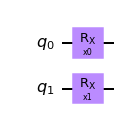

In [8]:
qc = angle_embedding(nb_features_circles)
qc.draw('mpl')

Features for the first datapoint: [0.22722472 0.39666575]


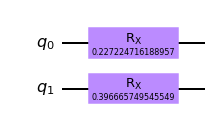

In [9]:
print('Features for the first datapoint:', x_train[0])

qc = qc.assign_parameters(x_train[0]) #data becomes parameters
qc.draw('mpl')

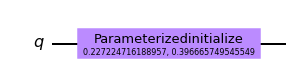

In [10]:
#We use a Qiskit Class [Class](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.circuit.library.RawFeatureVector.html)
qc = RawFeatureVector(nb_features_circles) 
qc = qc.assign_parameters(x_train[0])
qc.draw('mpl')

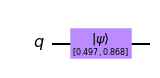

In [11]:
qc.decompose().draw('mpl')

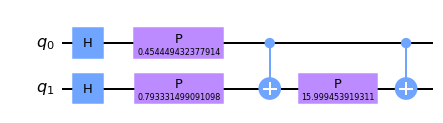

In [12]:
map_z = ZZFeatureMap(feature_dimension=nb_features_circles, reps=1, entanglement= "linear")
encode_circuit = map_z.assign_parameters(x_train[0])
encode_circuit.decompose().draw(output='mpl')

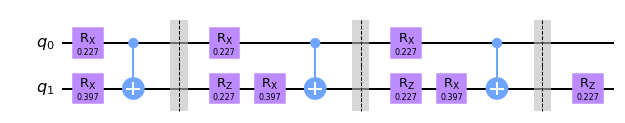

In [13]:
# Modify this function to customize your own circuit
def get_cicuit(n_qubits,n_layer, input_data):
    qc = QuantumCircuit(n_qubits)
    for layer in range(n_layer):
        for i in range(nb_features_circles):
            qc.rx(input_data[i], i)
        for i in range(n_qubits - 1):
            qc.cx(i, i+1)
            qc.barrier()
            qc.rz(input_data[i], i+1)
    return qc

qc = get_cicuit(n_qubits = 2,n_layer = 3, input_data = x_train[0])
qc.draw('mpl')

In [14]:
#Defining a quantum instance
simulator = Aer.get_backend('qasm_simulator')
shots = 8092
qinst = QuantumInstance(simulator, shots, SEED)

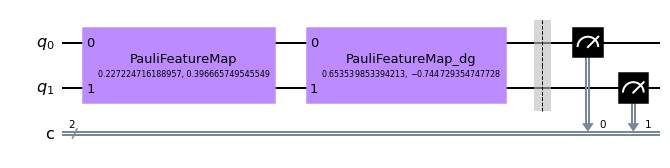

In [15]:
pauli_map = PauliFeatureMap(feature_dimension=nb_features_circles, reps=1, entanglement='linear')

#Building the kernel matrix
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=qinst)

#Constructing the inner product circuit for given datapoints and feature map
pauli_circuit = pauli_kernel.construct_circuit(x_train[0], x_train[1])

pauli_circuit.decompose().draw('mpl')

In [16]:
job = execute(pauli_circuit, backend = simulator, shots=shots)
counts = job.result().get_counts(pauli_circuit)
counts

{'01': 5610, '11': 1117, '00': 1074, '10': 291}

In [17]:
#How many times we count the 00 bitstring after our transition amplitude circuit. Changing the number of shots will obviously affect this value.
print(f"Transition amplitude: {counts['00']/sum(counts.values())}")

Transition amplitude: 0.13272367770637666


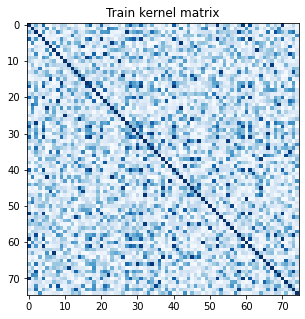

In [21]:
train_matrix= pauli_kernel.evaluate(x_vec=x_train)
test_matrix = pauli_kernel.evaluate(x_vec=x_test, y_vec=x_train)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

In [22]:
model = SVC(kernel= pauli_kernel.evaluate)

#Fiting the SVM model according to the given training data.
model.fit(x_train, y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000191D076DD30>>)

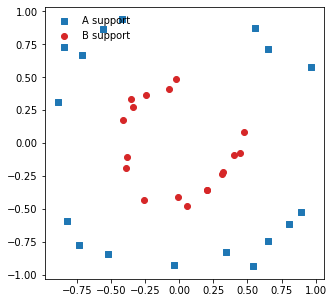

In [23]:
# print("Number of support vectors for each class:",model.n_support_)
# print("Indices of support vectors:", model.support_)

# Plot support vectors
plt.figure(figsize=(5, 5))

plt.scatter(x_train[model.support_[0:model.n_support_[0] ], 0],
            x_train[model.support_[0:model.n_support_[0] ], 1],
            marker='s', label="A support")
plt.scatter(x_train[model.support_[model.n_support_[0]:], 0],
            x_train[model.support_[model.n_support_[0]:], 1],
            marker='o', c='C3', label="B support")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [24]:
score = model.score(x_test, y_test)
print(f'Callable kernel classification test score: {score}')

Callable kernel classification test score: 1.0


In [25]:
# dataset is made up of 1797 8x8 images (https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html)
mnist = datasets.load_digits()

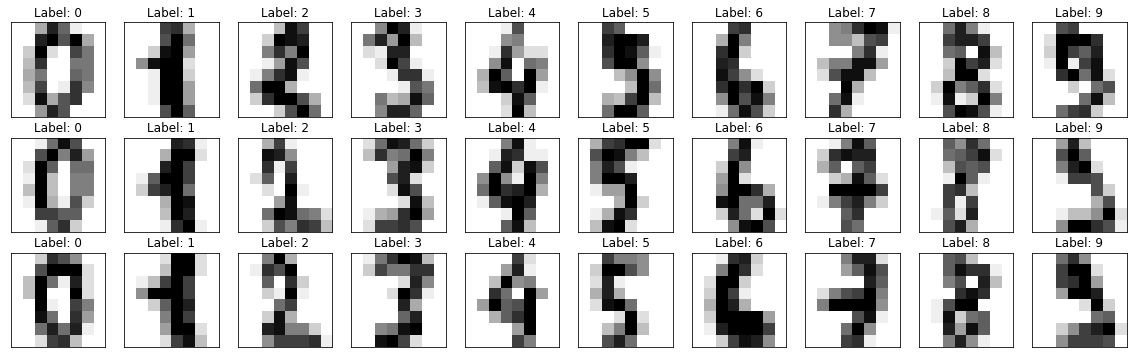

In [26]:
show_images(mnist.images, mnist.target)

In [27]:
# Filter digits and targets
labels = [0, 3]
x = mnist.images[[t in labels for t in mnist.target]]
y = mnist.target[[t in labels for t in mnist.target]]

# We keep only 24 images for each label
class_size = 24
x0 = x[y == labels[0]][:class_size:]
x1 = x[y == labels[1]][:class_size:]

In [28]:
# 80-20 split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
labels = np.array([0]*class_size + [1]*class_size)

x_train_full_scale, x_test_full_scale, y_train, y_test = train_test_split(np.concatenate((x0, x1), axis=0), labels, test_size=0.2, random_state=SEED, stratify=labels)

print(f'Size of the train set: {len(x_train_full_scale)}\nSize of the test set: {len(x_test_full_scale)}')

Size of the train set: 38
Size of the test set: 10


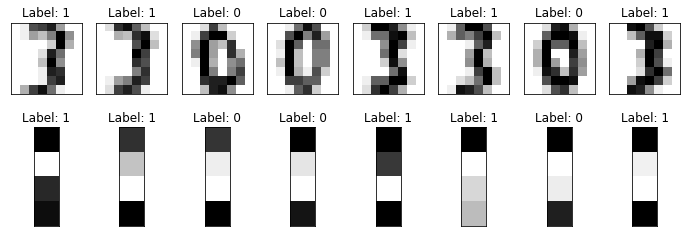

In [29]:
# https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
x_train = np.vstack([[resize(x_i, (4,1), anti_aliasing=False) for x_i in x_train_full_scale]])
x_test = np.vstack([[resize(x_i, (4,1), anti_aliasing=False) for x_i in x_test_full_scale]])

num_samples = 8
sources = [x_train_full_scale, x_train]
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(12, 4))
for i in range(num_samples):
    for s in range(len(sources)):
        axes[s, i].imshow(sources[s][i,:,:], cmap=plt.cm.gray_r)
        axes[s, i ].set_xticks([])
        axes[s, i].set_yticks([])
        axes[s, i].set_title(f"Label: {y_train[i]}")

In [30]:
# Reshape input data size from (4,1) to (4,)
x_train = x_train.reshape(x_train.shape[:-1])
x_test = x_test.reshape(x_test.shape[:-1])

# # Use one-hot encoding for labels: {0, 1} -> {[1,0], [0,1]}
# y_train = [np.eye(2)[0 if labels[0] == y_i else 1] for y_i in y_train]
# y_test = [np.eye(2)[0 if labels[0] == y_i else 1] for y_i in y_test]